In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import pickle
from pprint import pprint
from sklearn.model_selection import cross_validate, cross_val_score
from xgboost import XGBClassifier

%matplotlib inline

In [7]:
fs_dropouts = pd.read_csv('data/9th_grade_dropouts.csv', index_col='sid')

In [8]:
X = fs_dropouts.copy()
y = X.pop('dropout')
y

sid
2         0
5         0
12        1
13        0
14        0
         ..
111984    0
111985    0
111986    0
111988    1
111990    0
Name: dropout, Length: 52932, dtype: int64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [24]:
gboost = GradientBoostingClassifier()

In [26]:
scores = cross_validate(gboost, X, y, cv=5, scoring=['accuracy', 'precision'])

In [27]:
scores

{'fit_time': array([24.27008104, 22.59920621, 23.21701717, 22.31500292, 24.46762109]),
 'score_time': array([0.11384606, 0.15693402, 0.10865092, 0.10594201, 0.11747885]),
 'test_accuracy': array([0.85491641, 0.86370077, 0.86576611, 0.86406575, 0.85613074]),
 'test_precision': array([0.69565217, 0.71463023, 0.74006908, 0.73189655, 0.68485342])}

In [30]:
xgboost = XGBClassifier()

In [32]:
xgb_scores = cross_validate(xgboost, X, y, cv=5, scoring=['accuracy', 'precision'], verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/kiara/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:39:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:40:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:40:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:41:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.2min finished


In [33]:
xgb_scores

{'fit_time': array([32.28037691, 37.99310899, 34.10762215, 35.334337  , 50.98306608]),
 'score_time': array([0.06985807, 0.11456084, 0.1054337 , 0.08377504, 0.08400106]),
 'test_accuracy': array([0.8513271 , 0.86237839, 0.86264878, 0.86283771, 0.85206877]),
 'test_precision': array([0.66584362, 0.70280811, 0.71487264, 0.72151899, 0.66117647])}

In [34]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

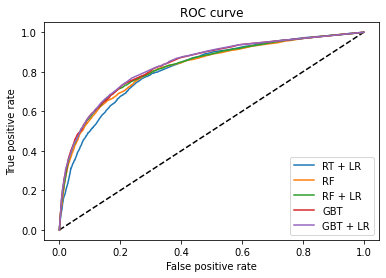

In [36]:
n_estimator = 10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
X_train, X_train_lr, y_train, y_train_lr = train_test_split(
    X_train, y_train, test_size=0.5)

# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,
                          random_state=0)

rt_lm = LogisticRegression(max_iter=1000)
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression(max_iter=1000)
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

# Supervised transformation based on gradient boosted trees
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression(max_iter=1000)
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)

# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
